# Semantic Image Segmentation with DeepLab in TensorFlow using Webcam OpenCV


Semantic Segmentation describes the task to assign a semantic label to every pixel in an image or video. Framing the topic of real-time segmentation, I applied the open-sourced DeepLab model by Google, which is implemented in TensorFlow. The following improvements have been made to the model since its release in 2016:
- DeepLab-V1: Using atrous convolution (a.k.a. dilated convolution: Introducing another parameter, the dilation rate, to convolution layer, what delivers a wider field of view at the same computation) to control the resolution of feature responses computation in CNNs.
- DeepLab-V2: Using atrous spatial pyramid pooling (ASPP), which helps to account for different object scales and improves accuracy.
- DeepLab-V3: Adding image-level feature to ASPP and applying batch normalization for easier training.
- DeepLab-V3+: Extension of DeepLabv3 by a decoder module to refine the segmentation results.

The architecture of the latest version of DeepLab (DeepLab-V3+) is composed of two steps:

1. Encoder: In this step, a pre-trained CNN extracts the essential information from the input image. For segmentation tasks, the essential information is the objects present in the image and their location.
2. Decoder: Here, we reconstruct the output of appropriate dimensions using the extracted information as input.


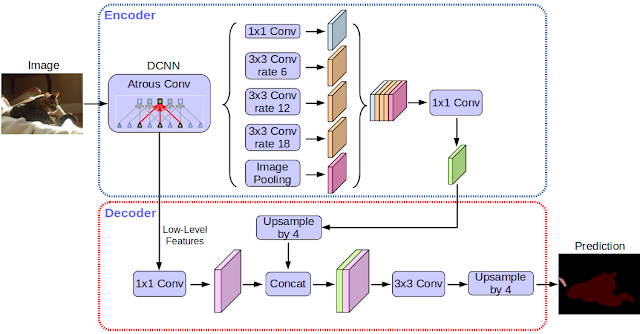

In [1]:
#Some imports
import collections
import os
import io
import sys
import tarfile
import tempfile
import urllib
from IPython import display
from ipywidgets import interact
from ipywidgets import interactive
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2

import tensorflow as tf
sys.path.append('utils')
import get_dataset_colormap

ModuleNotFoundError: No module named 'get_dataset_colormap'

In [ ]:
#Download URLs of the pre-trained Xception model
_MODEL_URLS = {
    'xception_coco_voctrainaug': 'http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval': 'http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}

Config = collections.namedtuple('Config', 'model_url, model_dir')

def get_config(model_name, model_dir):
    return Config(_MODEL_URLS[model_name], model_dir)

config_widget = interactive(get_config, model_name=_MODEL_URLS.keys(), model_dir='')
display.display(config_widget)

_TARBALL_NAME = 'deeplab_model.tar.gz'

config = config_widget.result

#create directory
model_dir = config.model_dir or tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model to %s, this might take a while...' % download_path)
urllib.request.urlretrieve(config.model_url, download_path)
print('download completed!')

In [ ]:
_FROZEN_GRAPH = 'frozen_inference_graph'

# Class to load DeepLab model and run inference.
class DeepLab(object)
    INPUT_TENSOR = 'ImageTensor:0'
    OUTPUT_TENSOR = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    # Creates and loads pretrained Deeplab model
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if _FROZEN_GRAPH in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
        if graph_def is None:
            raise RuntimeError('Cant find graph.')

        with self.graph.as_default():      
            tf.import_graph_def(graph_def, name='')
        
        self.sess = tf.Session(graph=self.graph)
     # Run inference on a single image
    def run(self, image):
        # Args: PIL.image object
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR,
            feed_dict={self.INPUT_TENSOR: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        # Output: RGB image resized from original input image, segmentation map of resized image 
        return resized_image, seg_map

In [ ]:
#Every time you run the code, a new model will be downloaded. Change the following line to a local path!
model = DeepLab(download_path)
cap = cv2.VideoCapture(0)
final = np.zeros((1, 384, 1026, 3))
while True:
    ret, frame = cap.read()
    cv2_im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_im = Image.fromarray(cv2_im)
    # model
    resized_im, seg_map = model.run(pil_im)
    # color of mask
    seg_image = get_dataset_colormap.label_to_color_image(
        seg_map, get_dataset_colormap.get_pascal_name()).astype(np.uint8)
    
    frame = np.array(pil_im)
    r = seg_image.shape[1] / frame.shape[1]
    dim = (int(frame.shape[0] * r), seg_image.shape[1])[::-1]
    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    resized = cv2.cvtColor(resized, cv2.COLOR_RGB2BGR)
    color_and_mask = np.hstack((resized, seg_image))
    cv2.imshow('frame', color_and_mask)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

